# Mathjax custom 

$ \newcommand{\opexpect}[3]{\langle #1 \vert #2 \vert #3 \rangle} $
$ \newcommand{\rarrow}{\rightarrow} $
$ \newcommand{\bra}{\langle} $
$ \newcommand{\ket}{\rangle} $

$ \newcommand{\up}{\uparrow} $
$ \newcommand{\down}{\downarrow} $

$ \newcommand{\mb}[1]{\mathbf{#1}} $
$ \newcommand{\mc}[1]{\mathcal{#1}} $
$ \newcommand{\mbb}[1]{\mathbb{#1}} $
$ \newcommand{\mf}[1]{\mathfrak{#1}} $

$ \newcommand{\vect}[1]{\boldsymbol{\mathrm{#1}}} $
$ \newcommand{\expect}[1]{\langle #1\rangle} $

$ \newcommand{\innerp}[2]{\langle #1 \vert #2 \rangle} $
$ \newcommand{\fullbra}[1]{\langle #1 \vert} $
$ \newcommand{\fullket}[1]{\vert #1 \rangle} $
$ \newcommand{\supersc}[1]{^{\text{#1}}} $
$ \newcommand{\subsc}[1]{_{\text{#1}}} $
$ \newcommand{\sltwoc}{SL(2,\mathbb{C})} $
$ \newcommand{\sltwoz}{SL(2,\mathbb{Z})} $

$ \newcommand{\utilde}[1]{\underset{\sim}{#1}} $

# Neural Networks With NetworkX

Reference: [Using neural nets to recognize handwritten digits](http://neuralnetworksanddeeplearning.com/chap1.html), Nielsen, Deep Learning

In [1]:
import matplotlib
matplotlib.use('qt4agg')
%matplotlib inline

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx import Graph, DiGraph

In [3]:
# import uud1 function from uuid module, to assign a unique id to each graph
from uuid import uuid1

## `switch` class defintion

In [10]:
# This class provides the functionality we want. You only need to look at
# this if you want to know how this works. It only needs to be defined
# once, no need to muck around with its internals.

# v = 'ten'
# for case in switch(v):
#     if case('one'):
#         print 1
#         break
#     if case('two'):
#         print 2
#         break
#     if case(): # default, could also just omit condition or 'if True'
#         print "something else!"
#         # No need to break here, it'll stop anyway

class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5, see below
            self.fall = True
            return True
        else:
            return False

## `generalizedPerceptron` class defintion

In [84]:
class generalizedPerceptron(Graph):
    
    numInputs = 0
    numOutputs = 0
    weights = []
    bias = 0
    _uuid = None
    
    _maxInputs = 100
    _maxOutputs = 100
    
    node_color_map = {}
    edge_color_map = {}

    node_colors = [] # list whose elements are colors for each node
    node_color_map = {'InternalNode': 'red',
                       'OutputNode': 'green',
                       'InputNode': 'blue'}
    
    node_color_dict = {}
    
    node_pos_dict = {}
    node_label_dict = {}
    
    edge_color_dict = {} # dictionary whose keys are edges and values are colors for each edge
    edge_colors = []
    
    free_input_nodes = []   # the number of free input and output nodes, respectively
    free_output_nodes = [] 

    
    def __init__(self, numIn = 2, numOut = 1, weights = None, bias = None):
        
        if not (isinstance(numIn,int) and numIn > 0):
            raise ValueError("numIn must be a non-zero positive integer")
        if numIn > self._maxInputs:
            raise ValueError("numIn cannot be greater than ",self._maxInputs)
            
        if not (isinstance(numOut,int) and numOut > 0):
            raise ValueError("numOut must be a non-zero positive integer")
        if numOut > self._maxOutputs:
            raise ValueError("numOut cannot be greater than ",self._maxOutputs)
            
        if weights!=None:
            if not isinstance(weights,list):
                raise ValueError("weights must be a list")
            if len(weights)!=numIn:
                raise ValueError("Number of weights must equal number of input nodes")
            if not all(isinstance(x,float) for x in weights):
                raise ValueError("weights must contain only real numbers")
            
        if bias!=None:
            if not isinstance(bias,float):
                raise ValueError("bias must be a real number")
    
        Graph.__init__(self)
        
        self._uuid = uuid1()
        
        self.numInputs = numIn
        self.numOutputs = numOut
        self.weights = weights
        self.bias = bias

#         DiGraph.add_node(self,0,type="Central")
        Graph.add_node(self,"CPU",type="InternalNode")
        self.node["CPU"]['pos'] = (0,0)
        self.node["CPU"]['color'] = 'green'
        self.node_label_dict["CPU"] = "CPU"
        
        for i in range(numIn):
            Graph.add_node(self,self._x(i),type="InputNode")
            Graph.add_edge(self,self._x(i),"CPU",type="InputEdge")
            self.node[self._x(i)]['connected'] = False
            self.node[self._x(i)]['color'] = 'blue'
            self.node_label_dict[self._x(i)] = self._x(i)
            
        for i in range(numOut):
            Graph.add_node(self,self._y(i),type="OutputNode")
            Graph.add_edge(self,"CPU",self._y(i),type="OutputEdge")
            self.node[self._y(i)]['connected'] = False
            self.node[self._y(i)]['color'] = 'red'
            self.node_label_dict[self._y(i)] = self._y(i)
        
        self.free_input_nodes = self.numInputs
        self.free_output_nodes = self.numOutputs
        
        self.assignPositions()
        self.assignNodeColors()
            
#         for i in range(numIn+numOut):
#             self.node[i+1]['connected'] = False

    def assignNodeColors(self):
        '''Assigns colors to nodes, depending on whether they are input, output or internal nodes'''
        self.node_colors = []
        for node in self.nodes():
            self.updateNodeColor(node)
            self.node_colors.append(self.node_color_dict[node])
#             self.node_colors.append(self.node_color_dict[self.node[n]['type']])
#             print(self.node_color_dict[self.node[n]['type']])
        

    def assignPositions(self):
        '''Assigns default (relative) co-ordinates to nodes'''
        self.node_pos_dict["CPU"] = (0,0)
        pxmax = None
        if self.numInputs % 2 == 0:
            even = True
            pxmax = self.numInputs/2 - 0.5
            px = pxmax
            for i in range(self.numInputs):
                self.node[self._x(i)]['pos'] = (-1,px)
                self.node_pos_dict[self._x(i)] = (-1,px)
                px -= 1.0
        else:
            even = False
            pxmax = (self.numInputs-1)/2
            px = pxmax
            for i in range(self.numInputs):
                self.node[self._x(i)]['pos'] = (-1,px)
                self.node_pos_dict[self._x(i)] = (-1,px)
                px -= 1.0
                
        if self.numOutputs % 2 == 0:
            even = True
            pxmax = self.numOutputs/2 - 0.5
            px = pxmax
            for i in range(self.numOutputs):
                self.node[self._y(i)]['pos'] = (1,px)
                self.node_pos_dict[self._y(i)] = (1,px)
                px -= 1.0
        else:
            even = False
            pxmax = (self.numOutputs-1)/2
            px = pxmax
            for i in range(self.numOutputs):
                self.node[self._y(i)]['pos'] = (1,px)
                self.node_pos_dict[self._y(i)] = (1,px)
                px -= 1.0
    
    def updateNodeColor(self,node):
        self.node_color_dict[node] = self.node_color_map[self.node[node]['type']]

    def draw(self, draw_nodes=True, draw_edges=True, draw_labels=False):
        if(draw_nodes==False and draw_edges==False and draw_labels==True):
            raise ValueError("If draw_labels is set to True, then one of draw_nodes or draw_edges must also be True")
        plt.axis('off')
#         self.node_colors = []
        
#         for node in self.nodes():
#             self.node_colors.append(self.node_color_dict[node])
            
        if draw_nodes:
            nx.draw_networkx_nodes(self,pos=self.node_pos_dict,node_color=self.node_colors)
        if draw_edges:
            nx.draw_networkx_edges(self,pos=self.node_pos_dict)
        if draw_labels:
            nx.draw_networkx_labels(self,pos=self.node_pos_dict,labels=self.node_label_dict)
#         nx.draw(self,pos=self.node_pos_dict,labels=self.node_label_dict,node_color=self.node_colors)
    
    def _x(self,i):
        return "x"+str(i)
    
    def _y(self,i):
        return "y"+str(i)
    
#     def connectPerceptron(self,p2):
#         '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
#         output edge of this node'''
        
#         if not isinstance(p2,Perceptron):
#             raise ValueError("First argument must be an object of type Perceptron")
            
#         p3 = Perceptron(self.numInputs, p2.numOutputs)
        
#         if p2.free_input_nodes > 0:
#             for i in range(p2.numInputs):
#                 if p2.node[self._x(i)]['connected'] == False:
#                     p2.node[self._x(i)]['connected'] = True
#                     p2.node[self._x(i)]['inputFrom'] = {'perceptron': self._uuid}
#                     p2.free_input_nodes -= 1
#                     break
#         else:
#             raise RuntimeWarning("No free input edges in second Perceptron")
        
#         if self.free_output_nodes > 0:
#             for i in range(self.numOutputs):
#                 if self.
        
#         for i in range(self.numInputs):
#             if self.node[i+1]['connected'] == False:
#                 self.node[i+1]['connected'] = True
#                 self.node[i+1]['outputTo'] = {'perceptron': p2._uuid, 'outputNode': i+1}
#                 break

    
    def __hash__(self):
        '''Defines __hash__ method in order to make class sortable, hashable
        Reference: https://stackoverflow.com/a/7152650/506434
        '''
        return hash(repr(self))
        

In [85]:
gp1 = generalizedPerceptron()

In [19]:
gp1.node["CPU"]

{'color': 'green', 'pos': (0, 0), 'type': 'InternalNode'}

In [20]:
for n in gp1.nodes():
    print(n,gp1.node[n],gp1.neighbors(n))

x0 {'color': 'blue', 'connected': False, 'type': 'InputNode', 'pos': (-1, 0.5)} ['CPU']
x1 {'color': 'blue', 'connected': False, 'type': 'InputNode', 'pos': (-1, -0.5)} ['CPU']
y0 {'color': 'red', 'connected': False, 'type': 'OutputNode', 'pos': (1, 0.0)} ['CPU']
CPU {'color': 'green', 'pos': (0, 0), 'type': 'InternalNode'} ['x0', 'x1', 'y0']


In [8]:
gp1.node_label_dict

{'CPU': 'CPU', 'x0': 'x0', 'x1': 'x1', 'y0': 'y0'}

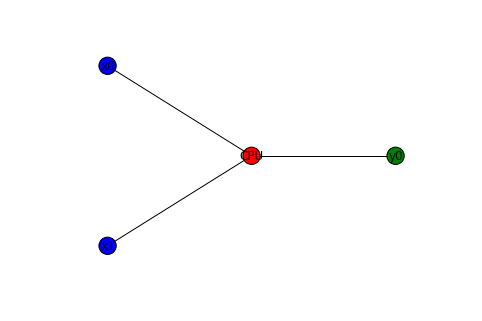

In [27]:
nx.draw(gp1,pos=gp1.node_pos_dict,labels=gp1.node_label_dict,node_color=gp1.node_colors)

{'CPU': <matplotlib.text.Text at 0x108635ba8>,
 'x0': <matplotlib.text.Text at 0x1083ef390>,
 'x1': <matplotlib.text.Text at 0x108635128>,
 'y0': <matplotlib.text.Text at 0x108635668>}

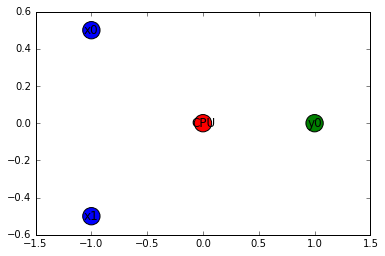

In [26]:
nx.draw_networkx_nodes(gp1,pos=gp1.node_pos_dict,labels=gp1.node_label_dict,node_color=gp1.node_colors)
nx.draw_networkx_labels(gp1,pos=gp1.node_pos_dict,labels=gp1.node_label_dict)

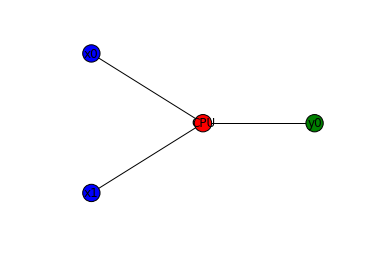

In [86]:
gp1.draw(draw_labels=True)

{'CPU': <matplotlib.text.Text at 0x108174f28>,
 'x0': <matplotlib.text.Text at 0x1089d1b70>,
 'x1': <matplotlib.text.Text at 0x107f54e48>,
 'y0': <matplotlib.text.Text at 0x108174470>}

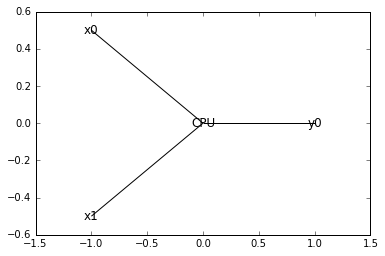

In [38]:
# nx.draw_networkx_nodes(gp1,pos=gp1.node_pos_dict,node_color=gp1.node_colors)
nx.draw_networkx_edges(gp1,pos=gp1.node_pos_dict)
nx.draw_networkx_labels(gp1,pos=gp1.node_pos_dict,labels=gp1.node_label_dict)

In [87]:
gp2 = generalizedPerceptron(numIn=3,numOut=3)

In [88]:
gp3 = nx.compose(gp1,gp2)

In [91]:
gp3.nodes()

['x0', 'x1', 'CPU', 'y1', 'x2', 'y2', 'y0']

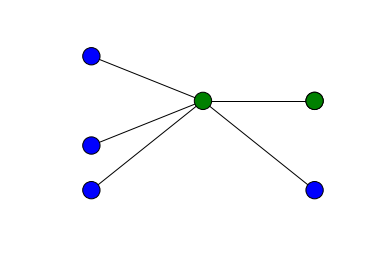

In [92]:
gp3.draw()

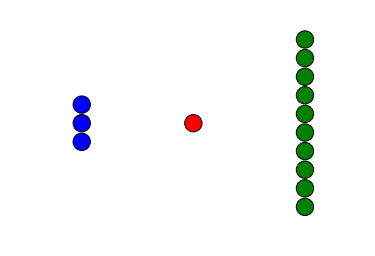

In [80]:
gp2.draw(draw_edges=False)

In [72]:
for node in gp2.nodes():
    print(node,gp2.node_color_dict[node])

y1 green
CPU red
x2 blue
y2 green
x0 blue
x1 blue
y0 green


In [67]:
print(gp2.node_color_dict.values())

dict_values(['green', 'green', 'green', 'blue', 'blue', 'blue', 'red'])


In [59]:
print(gp2.node_colors)

['blue', 'blue', 'green', 'red', 'blue', 'green', 'red', 'blue', 'green', 'red', 'green', 'green', 'blue', 'green', 'red', 'green', 'green', 'red', 'blue', 'green', 'blue', 'blue', 'green']


In [124]:
gp1.node_colors

['green', 'blue', 'blue', 'red']

## `Perceptron` class defintion

In [52]:
class Perceptron(DiGraph):
    
    numInputs = 0
    numOutputs = 0
    weights = []
    bias = 0
    _uuid = None
    
    _maxInputs = 100
    _maxOutputs = 100
    
    def __init__(self, numIn = 2, numOut = 1, weights = None, bias = None):
        
        if not (isinstance(numIn,int) and numIn > 0):
            raise ValueError("numIn must be a non-zero positive integer")
        if numIn > self._maxInputs:
            raise ValueError("numIn cannot be greater than ",self._maxInputs)
            
        if not (isinstance(numOut,int) and numOut > 0):
            raise ValueError("numOut must be a non-zero positive integer")
        if numOut > self._maxOutputs:
            raise ValueError("numOut cannot be greater than ",self._maxOutputs)
            
        if weights!=None:
            if not isinstance(weights,list):
                raise ValueError("weights must be a list")
            if len(weights)!=numIn:
                raise ValueError("Number of weights must equal number of input nodes")
            if not all(isinstance(x,float) for x in weights):
                raise ValueError("weights must contain only real numbers")
            
        if bias!=None:
            if not isinstance(bias,float):
                raise ValueError("bias must be a real number")
    
        DiGraph.__init__(self)
        
        self._uuid = uuid1()
        
        self.numInputs = numIn
        self.numOutputs = numOut
        self.weights = weights
        self.bias = bias

#         DiGraph.add_node(self,0,type="Central")
        DiGraph.add_node(self,0,type="Central")
        
        for i in range(numIn):
            DiGraph.add_node(self,i+1,type="InputNode")
            DiGraph.add_edge(self,i+1,0,type="InputEdge")
            
        for i in range(numOut):
            DiGraph.add_node(self,i+numIn+1,type="OutputNode")
            DiGraph.add_edge(self,0,i+numIn+1,type="OutputEdge")
            
        for i in range(numIn+numOut):
            self.node[i+1]['connected'] = False
    
    def connectPerceptron(self,p2):
        '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
        output edge of this node'''
        
        if not isinstance(p2,Perceptron):
            raise ValueError("First argument must be an object of type Perceptron")
            
        p3 = Perceptron(self.numInputs, p2.numOutputs)
        
        for i in range(p2.numOutputs):
            if p2.node[i+1]['connected'] == False:
                p2.node[i+1]['connected'] = True
                p2.node[i+1]['inputFrom'] = {'perceptron': self._uuid, 'inputNode': i+1 }
                break
            
        for i in range(self.numInputs):
            if self.node[i+1]['connected'] == False:
                self.node[i+1]['connected'] = True:
                self.node[i+1]['outputTo'] = {'perceptron': p2._uuid, 'outputNode': i+1}
                break

    
    def __hash__(self):
        '''Defines __hash__ method in order to make class sortable, hashable
        Reference: https://stackoverflow.com/a/7152650/506434
        '''
        return hash(repr(self))
        

In [53]:
p1 = Perceptron()

In [60]:
p1[0]

{3: {'type': 'OutputEdge'}}

In [43]:
type(_42)

dict

In [55]:
p1.nodes()

[0, 1, 2, 3]

In [56]:
p1.edges()

[(0, 3), (1, 0), (2, 0)]

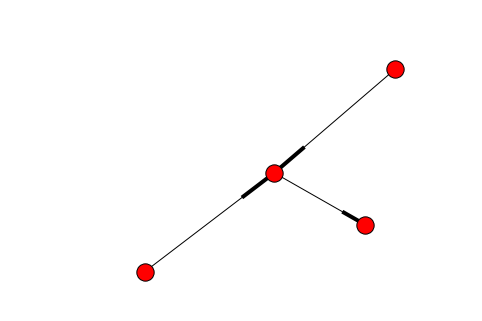

In [40]:
nx.draw(p1)

## `SimplePerceptron` class defintion

In [52]:
class SimplePerceptron(DiGraph):
    
    numInputs = 0
    numOutputs = 1
    weights = []
    bias = 0
    _uuid = None
    
    _maxInputs = 100
    _maxOutputs = 1
    
    def __init__(self, numIn = 2, numOut = 1, weights = None, bias = None):
        
        if not (isinstance(numIn,int) and numIn > 0):
            raise ValueError("numIn must be a non-zero positive integer")
        if numIn > self._maxInputs:
            raise ValueError("numIn cannot be greater than ",self._maxInputs)
            
        if not (isinstance(numOut,int) and numOut > 0):
            raise ValueError("numOut must be a non-zero positive integer")
        if numOut > self._maxOutputs:
            raise ValueError("numOut cannot be greater than ",self._maxOutputs)
            
        if weights!=None:
            if not isinstance(weights,list):
                raise ValueError("weights must be a list")
            if len(weights)!=numIn:
                raise ValueError("Number of weights must equal number of input nodes")
            if not all(isinstance(x,float) for x in weights):
                raise ValueError("weights must contain only real numbers")
            
        if bias!=None:
            if not isinstance(bias,float):
                raise ValueError("bias must be a real number")
    
        DiGraph.__init__(self)
        
        self._uuid = uuid1()
        
        self.numInputs = numIn
        self.numOutputs = numOut
        self.weights = weights
        self.bias = bias

#         DiGraph.add_node(self,0,type="Central")
        DiGraph.add_node(self,0,type="Central")
        
        for i in range(numIn):
            DiGraph.add_node(self,i+1,type="InputNode")
            DiGraph.add_edge(self,i+1,0,type="InputEdge")
            
        for i in range(numOut):
            DiGraph.add_node(self,i+numIn+1,type="OutputNode")
            DiGraph.add_edge(self,0,i+numIn+1,type="OutputEdge")
            
        for i in range(numIn+numOut):
            self.node[i+1]['connected'] = False
    
    def connectPerceptron(self,p2):
        '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
        output edge of this node'''
        
        if not isinstance(p2,Perceptron):
            raise ValueError("First argument must be an object of type Perceptron")
            
        p3 = Perceptron(self.numInputs, p2.numOutputs)
        
        for i in range(p2.numOutputs):
            if p2.node[i+1]['connected'] == False:
                p2.node[i+1]['connected'] = True
                p2.node[i+1]['inputFrom'] = {'perceptron': self._uuid, 'inputNode': i+1 }
                break
            
        for i in range(self.numInputs):
            if self.node[i+1]['connected'] == False:
                self.node[i+1]['connected'] = True:
                self.node[i+1]['outputTo'] = {'perceptron': p2._uuid, 'outputNode': i+1}
                break

    
    def __hash__(self):
        '''Defines __hash__ method in order to make class sortable, hashable
        Reference: https://stackoverflow.com/a/7152650/506434
        '''
        return hash(repr(self))
        

In [ ]:
def connectPerceptrons(p1,p2):
    '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
    output edge of p1'''
    

In [57]:
for n in p1.nodes_iter():
    print(p1.node[n])

{'type': 'Central'}
{'type': 'InputNode', 'connected': False}
{'type': 'InputNode', 'connected': False}
{'type': 'OutputNode', 'connected': False}


In [51]:
for n in p1.nodes_iter():
    p1.node[n]['connected'] = False
    print(p1.node[n])

{'type': 'Central', 'connected': False}
{'type': 'InputNode', 'connected': False}
{'type': 'InputNode', 'connected': False}
{'type': 'OutputNode', 'connected': False}


In [8]:
hash?

In [9]:
import sys

In [10]:
sys.getsizeof(p1)

56

In [11]:
import uuid

In [27]:
uuid.uuid4()

UUID('85e05649-c82e-49d5-b5e5-c0cf97949750')

In [12]:
uuid.uuid1()

UUID('f7510f14-ca3f-11e5-8919-60f81dd1cf3a')

In [13]:
from uuid import uuid1

In [14]:
uuid1?

In [21]:
sys.getsizeof?

In [20]:
sys.getsizeof(p1.edges())

112

In [26]:
sys.getsizeof(_25)

288

In [6]:
nx.draw_graphviz(p1,prog='neato')

IndexError: list index out of range

In [9]:
import pydot

In [10]:
from pydot import pydot

In [ ]:
pydot.D

In [47]:
nx.draw?

In [4]:
nx.graph??

In [48]:
nx.draw_graphviz?

In [24]:
Graph.add_edge?

In [30]:
nx.DiGraph?